<a href="https://colab.research.google.com/github/arpan-das-astrophysics/deep21-unet/blob/main/deep21_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# a self-contained deep21 tutorial

![unet-diagram](https://raw.githubusercontent.com/tlmakinen/deep21/master/tutorial/panels-white.gif)
$\quad$


[T. Lucas Makinen](https://orcid.org/0000-0002-3795-6933) (this notebook), [Lachlan T. Lancaster](https://orcid.org/0000-0002-0041-4356), [Francisco Villaescusa-Navarro](https://orcid.org/0000-0002-4816-0455), [Peter Melchior](), Laurence Perrault-Levasseur, Shirley Ho & David Spergel

$\quad$
![unet-diagram](https://raw.githubusercontent.com/tlmakinen/deep21/master/tutorial/unet-diagram.png)
$\quad$

Here we'll walk through the use of the [deep21 UNet module](https://github.com/tlmakinen/deep21/) created for foreground-cosmological signal separation for 21cm cosmology. We've simplified the approach quite a bit, but hope that this tutorial (geared towards an upper undergraduate-level audience) will provide guidance for use in either 21cm or other high-dimensional image processing tasks. For a pop overview, see this [Twitter thread](https://twitter.com/LucasMakinen/status/1325871656745771008?s=20).

## set up notebook
First we're going to pull in the code from GitHub repository, and install necessary packages onto the Colab platform.

In [1]:
!git clone https://github.com/tlmakinen/deep21.git

Cloning into 'deep21'...
remote: Enumerating objects: 479, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 479 (delta 32), reused 20 (delta 9), pack-reused 421
Receiving objects: 100% (479/479), 33.53 MiB | 12.49 MiB/s, done.
Resolving deltas: 100% (297/297), done.


In [2]:
# install healpy dependency
!pip install healpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 20.9 MB/s eta 0:00:00


In [3]:
cd deep21/

/content/deep21


In [4]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.7 MB/s eta 0:00:00


In [5]:
# import the required Libraries
from __future__ import absolute_import, division, print_function
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import healpy as hp
import os

print(tf.__version__)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


2.12.0


In [6]:
# plot settings
import matplotlib

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
})

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()
%matplotlib inline

# load 21 cm data

The data for this tutorial has already been formatted into HEALPix voxels. The dataset shape for both observed and clean cosmological signal is $(N_{\rm voxels}, N_x, N_y, N_\nu) = (192,64,64,64)$. To do the PCA preprocessing we'll flatten the data back into HEALPix maps (like those obtained from `.fits` files in the full code). Then the PCA function will rearrange the PCA residual map *back* to voxel shape.

$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \rm foregrounds\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ cosmological\ signal $

$\quad$
![unet-diagram](https://raw.githubusercontent.com/tlmakinen/deep21/master/tutorial/panel-comparison.png)
$\quad$


We're going to load 5 full-sky example simulations to demonstrate training and PCA subtraction. We'll pull them in from Zenodo.

**Note:** this might take a minute or two (files are $\sim$2 Gb each)

**if you're in a hurry:** uncomment the lines below to download a single simulation from the Zenodo repository. You will not be able to compute power spectrum estimations for and entire predicted sky, but you will be able to make the voxel-wise predictions.

___


In [7]:
#We will use the files from google drive instead

# !wget https://zenodo.org/record/4133772/files/cosmo.npy
# !wget https://zenodo.org/record/4133772/files/obs.npy
# # !wget https://zenodo.org/record/4133772/files/cosmo-single.npy
# # !wget https://zenodo.org/record/4133772/files/obs-single.npy

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!ls "/content/drive/MyDrive/deep21_data"

cosmo.npy  obs.npy


In [9]:
index_arr = np.load('./sim_info/rearr_nside4.npy')

# read in the observed and cosmological maps -- change to `cosmo-single.npy`
# if using smaller dataset
cosmo = np.load('/content/drive/MyDrive/deep21_data/cosmo.npy')
obs_map = np.load('/content/drive/MyDrive/deep21_data/obs.npy')

# define the (simplified) PCA preprocessing function
Here we code a simplified version of the probabilistic PCA subtraction we used to preprocess our maps. We'll remove the first 3 components and use the residual to train our deep network.
___


In [10]:
index_arr = np.load('./sim_info/rearr_nside4.npy')
# ACTUAL FREQUENCY MEASUREMENTS
nutable = './sim_info/' + "nuTable.txt"
(bn,nu_bot,nu_top,z_bot,z_top) = np.loadtxt(nutable).T
nu_arr = ((nu_bot + nu_top)/2.)[:-1]

In [11]:
# first some additional packages that we'll need
import healpy as hp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------------------------------
def gen_rearr(nside):
    # recursive funtion for finding the right
    # ordering for the nested pixels
    if (nside==1):
        return np.array([0,1,2,3])
    else:
        smaller = np.reshape(gen_rearr(nside-1),(2**(nside-1),2**(nside-1)))
        npixsmaller = 2**(2*(nside-1))
        top = np.concatenate((smaller,smaller+npixsmaller),axis=1)
        bot = np.concatenate((smaller+2*npixsmaller,smaller+3*npixsmaller),axis=1)
        whole = np.concatenate((top,bot))
        return whole.flatten()

# ----------------------------------------------------------------------------

# for this demo, we'll pull in a pre-computed index to get our data
# from the shape (192, N_x, N_y, N_nu) to the HEALPix ring
# data format (192*64*64, 64)

def pca_subtraction(input_map, n_comp, index_array, n_nu=None,
                    nu_arr=None, nu_start=0, n_nu_out=64, n_nu_avg=3):

    # "GLOBAL" parameters ----------------------------------------------------
    MAP_NSIDE = 256
    SIM_NSIDE = MAP_NSIDE
    WINDOW_NSIDE = 4
    NUM_SIMS = 1
    # resolution of the outgoing window
    NPIX_WINDOW = (MAP_NSIDE/WINDOW_NSIDE)**2
    # actual side length of window
    WINDOW_LENGTH = int(np.sqrt(NPIX_WINDOW))
    # ------------------------------------------------------------------------

    # rearrange indices
    rearr = gen_rearr(int(np.log2(MAP_NSIDE/WINDOW_NSIDE)))
    nwinds = int(hp.nside2npix(WINDOW_NSIDE))

    if nu_arr is not None:
        print('working in frequency range ', nu_arr[nu_start], '--',
                                nu_arr[nu_start + (n_nu*n_nu_avg)-1],
                ' MHz')

    # initialize the PCA algorithm
    pca = PCA()
    # allocate the output array
    pca_reduced_out = np.zeros(input_map.shape)

    # flatten input map into full-sky maps stacked in frequency
    input_map = input_map.reshape((-1, 64))[index_array]

    # do PCA removal of n_comp components
    pca.fit(input_map)
    obs_pca = pca.transform(input_map)
    ind_arr = np.reshape(np.arange(np.prod(obs_pca.shape)),obs_pca.shape)


    mask = np.ones(obs_pca.shape)
    for i in range(n_comp,obs_pca.shape[1]):
        mask[ind_arr%obs_pca.shape[1]==i] = 0
    obs_pca = obs_pca*mask
    obs_pca_red = pca.inverse_transform(obs_pca)
    print("Now I'm doing the minimum subtraction...")
    print("...removing the first %d principal components"%(n_comp))
    obs_pca_red = input_map - obs_pca_red

    # get the array indices in the RING formulation
    inds = np.arange(hp.nside2npix(MAP_NSIDE))
    # transfer these to what they would be in the NESTED formulation
    inds_nest = hp.ring2nest(MAP_NSIDE,inds)

    sig = obs_pca_red

    for PIX_SELEC in np.arange(hp.nside2npix(WINDOW_NSIDE)):
        # get the indices of the pixels which actually are in the larger pixel
        inds_in = np.where((inds_nest//NPIX_WINDOW)==PIX_SELEC)
        to_rearr_inds = inds_nest[inds_in] - PIX_SELEC*NPIX_WINDOW
        to_rearr = obs_pca_red[inds_in]
        to_rearr = (to_rearr[np.argsort(to_rearr_inds)])[rearr]
        to_rearr = np.reshape(to_rearr,(WINDOW_LENGTH,WINDOW_LENGTH,n_nu_out))
        ind = (0)*nwinds + PIX_SELEC
        pca_reduced_out[ind] = to_rearr

    return pca_reduced_out

Now that we've loaded our data in and defined our function, let's perform the PCA preprocessing, one sky at a time.


In [12]:
%%time
n_side = 4   # data arrangement parameter
n_voxels = hp.nside2npix(4)
print('we have %d voxels per sky simulation'%(n_voxels))

splt = obs_map.shape[0]//n_voxels
print("we\'re working with %d sky simulations"%(splt))
pca3 = []

for i,sky in enumerate(np.split(obs_map, splt, axis=0)):
# do the PCA subtraction for each map separately
    print('starting PCA subtraction for sky %d'%(i+1))
    pca3.append(pca_subtraction(sky, 3, index_arr, n_nu=64,
                    nu_arr=nu_arr, nu_start=0, n_nu_out=64, n_nu_avg=3))

pca3 = np.concatenate(pca3, axis=0)
print('I put the PCA-3 subtraction put back into this shape : ', pca3.shape)

we have 192 voxels per sky simulation
we're working with 5 sky simulations
starting PCA subtraction for sky 1
working in frequency range  350.33568 -- 492.10404  MHz
Now I'm doing the minimum subtraction...
...removing the first 3 principal components
starting PCA subtraction for sky 2
working in frequency range  350.33568 -- 492.10404  MHz
Now I'm doing the minimum subtraction...
...removing the first 3 principal components
starting PCA subtraction for sky 3
working in frequency range  350.33568 -- 492.10404  MHz
Now I'm doing the minimum subtraction...
...removing the first 3 principal components
starting PCA subtraction for sky 4
working in frequency range  350.33568 -- 492.10404  MHz
Now I'm doing the minimum subtraction...
...removing the first 3 principal components
starting PCA subtraction for sky 5
working in frequency range  350.33568 -- 492.10404  MHz
Now I'm doing the minimum subtraction...
...removing the first 3 principal components
I put the PCA-3 subtraction put back int

# build the UNet model
The UNet module used for this analysis is built using Keras (with Tensorflow backend). Keras is a really intuitive deep learning library, but still requires lots of hyperparameter tuning. We'll declare a dictionary of parameters to get the UNet up and running.

**Note:** this toy model we're building is much simpler than the one used in the publication. For the full `deep21` implementation we opted for a depth of 6 (halving input voxels $6$ times). To deal with the large number of weights to train, we parallelized training over 4 GPUs in parallel to handle the large number of parameters.

In [13]:
from unet import unet_3d
# DEFINE UNET INPUT PARAMS
params = {
    'nu_dim'        : 64,
    'x_dim'         : 64,
    'n_filters'     : 32,
    'conv_width'    : 3,
    'network_depth' : 3,
    'batch_size'    : 16,
    'num_epochs'    : 50,
    'act'           : 'relu',
    'lr'            : 0.0002,
    'wd'            : 1e-5,
    'batchnorm_in'  : True,
    'batchnorm_out' : True,
    'batchnorm_up'  : True,
    'batchnorm_down': True,
    'momentum'      :  0.02,
    'model_num'     : 1,
    'load_model'    : False,
}

In [14]:
net = unet_3d.unet3D(n_filters=params['n_filters'],
                      conv_width=params['conv_width'],
                      nu_dim=params['nu_dim'],
                      x_dim=params['x_dim'],
                      network_depth=params['network_depth'],
                      batchnorm_down=params['batchnorm_down'],
                      batchnorm_in=params['batchnorm_in'],
                      batchnorm_out=params['batchnorm_out'],
                      batchnorm_up=params['batchnorm_up'],
                      momentum=params['momentum']
                      )
net = net.build_model()

In [15]:
net.compile(optimizer=tf.optimizers.Adam(learning_rate=params['lr'],
                                                 beta_1=0.9, beta_2=0.999, amsgrad=False),
                                                 loss="logcosh",metrics=["mse", "logcosh"])

In [16]:
!mv e

mv: missing destination file operand after 'e'
Try 'mv --help' for more information.


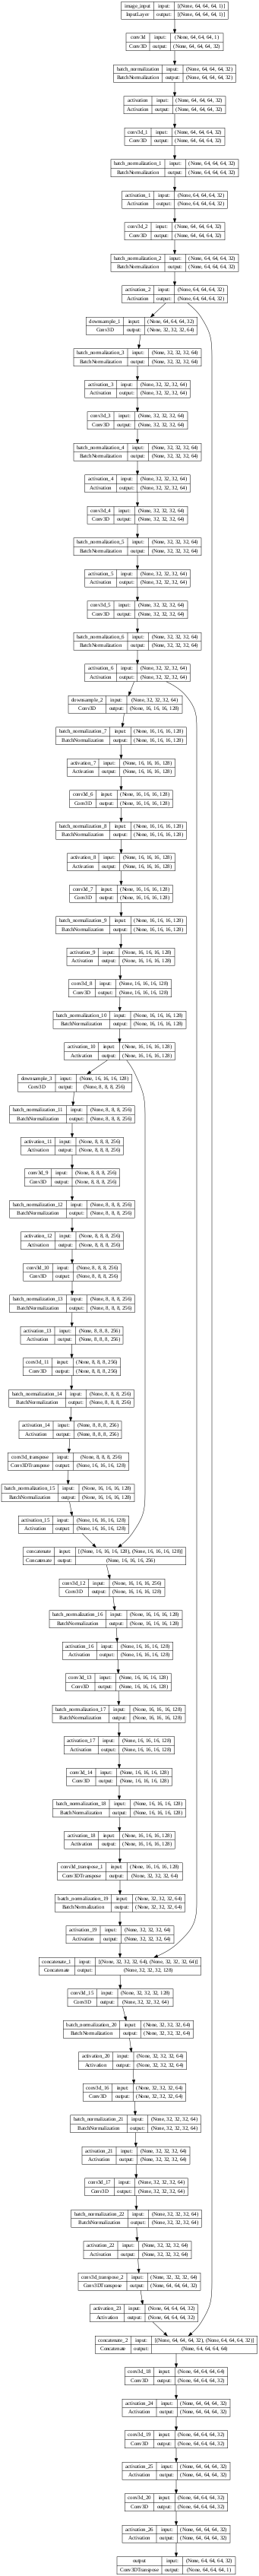

In [17]:
# take a look at what our model looks like with either of these two methods:
from keras.utils import plot_model
plot_model(net, dpi=36, show_shapes=True) # change dpi parameter to "zoom in"
# net.summary()

# train the UNet
Now we'll split our single simulation into training, testing, and validation sets. In our actual `deep21` experiment, we split 100's of *simulations* into these sets, but for simplicity we'll stick to the $5\times192$ voxels for this sample simulation.

Furthermore, in the publication we implemented an augmented training scheme, namely each full-sky simulation was subject to

1.   Randomly-generated Gaussian observational noise
2.   Random rotations on the sphere

We found that this enabled the network to learn to distinguish foregrounds from cosmological signal on scales larger than our input voxel size.



In [22]:
# for a quicker run using a single simulation,
# uncomment and use this train-test-split:

# x = np.expand_dims(pca3, axis=-1)
# y = np.expand_dims(cosmo, axis=-1)

# N_TRAIN = int(0.8*192)
# N_VAL  = int(0.1*192)

# x_train = x[:N_TRAIN]
# x_val   = x[N_TRAIN:-N_VAL]
# x_test  = x[-N_VAL:]

# y_train = y[:N_TRAIN]
# y_val   = y[N_TRAIN:-N_VAL]
# y_test  = y[-N_VAL:]


In [18]:
# put data into a train-validation-test split
# 3 train, 1 val, 1 test skies

x = np.expand_dims(pca3, axis=-1)
y = np.expand_dims(cosmo, axis=-1)

N_TRAIN = int(3*192)
N_VAL  = int(1*192)

x_train = x[:N_TRAIN]
x_val   = x[N_TRAIN:-N_VAL]
x_test  = x[-N_VAL:]

y_train = y[:N_TRAIN]
y_val   = y[N_TRAIN:-N_VAL]
y_test  = y[-N_VAL:]

Next we'll fit the UNet to the training data, checking the validation set after every epoch (pass through the whole dataset). We'll train for just 10 epochs and see how our network performs on the test data.

**Note:** if you're running this for all 4 training and validation simulations, this could take a while

In [19]:
history = net.fit(x_train, y_train, batch_size=4, epochs=10,
                  validation_data=(x_val, y_val))

Epoch 1/10
144/144 [==============================] - 177s 955ms/step - loss: 0.0140 - mse: 0.0288 - logcosh: 0.0140 - val_loss: 0.0066 - val_mse: 0.0133 - val_logcosh: 0.0066
Epoch 2/10
144/144 [==============================] - 149s 1s/step - loss: 0.0054 - mse: 0.0110 - logcosh: 0.0054 - val_loss: 0.0047 - val_mse: 0.0095 - val_logcosh: 0.0047
Epoch 3/10
144/144 [==============================] - 149s 1s/step - loss: 0.0042 - mse: 0.0085 - logcosh: 0.0042 - val_loss: 0.0038 - val_mse: 0.0077 - val_logcosh: 0.0038
Epoch 4/10
144/144 [==============================] - 141s 982ms/step - loss: 0.0035 - mse: 0.0071 - logcosh: 0.0035 - val_loss: 0.0033 - val_mse: 0.0066 - val_logcosh: 0.0033
Epoch 5/10
144/144 [==============================] - 141s 983ms/step - loss: 0.0031 - mse: 0.0062 - logcosh: 0.0031 - val_loss: 0.0029 - val_mse: 0.0059 - val_logcosh: 0.0029
Epoch 6/10
144/144 [==============================] - 141s 983ms/step - loss: 0.0028 - mse: 0.0056 - logcosh: 0.0028 - val_los

In [20]:
# save model weights !
import os
os.mkdir('./model')
net.save_weights('./model/tutorial_weights.h5')

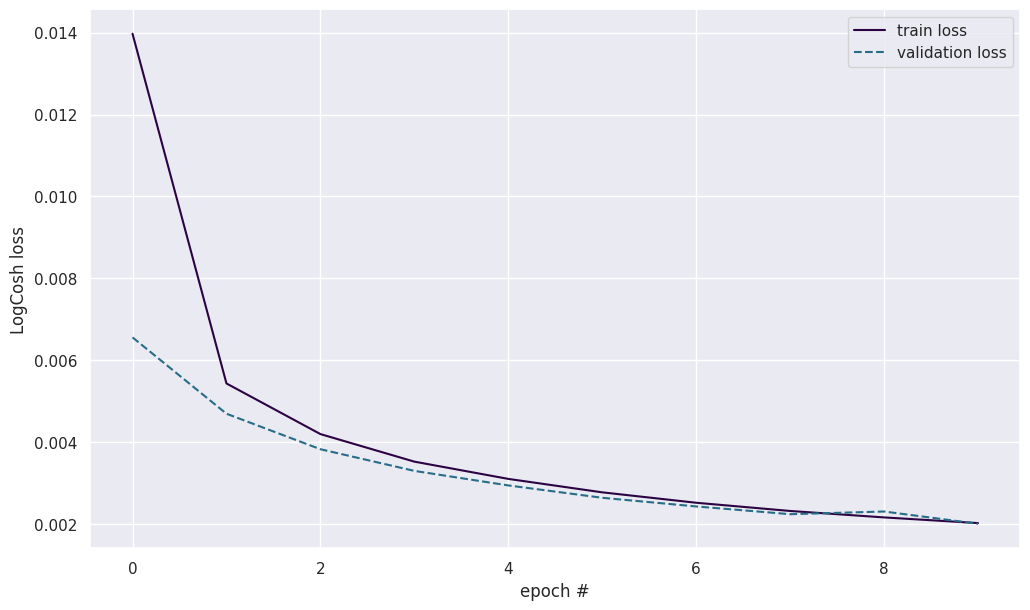

In [21]:
# plot parameters
plt.figure(figsize=(12,7))
colors = ['#2c0342', '#223167', '#286d87', '#4fb49d', '#9af486']
#labels = [r'$x_0 = $' + str(x0) for x0 in x0_arr]

# plot training history and validation scores
plt.plot(history.history['loss'], color=colors[0],
         label='train loss')
plt.plot(history.history['val_loss'], color=colors[2], linestyle='--',
         label='validation loss')
plt.legend()
plt.xlabel('epoch #')
plt.ylabel('LogCosh loss')
plt.show()

# make prediction & plot voxel slices

In [22]:
# make prediction
y_pred = net.predict(x_test)

6/6 [==============================] - 28s 2s/step


<ipython-input-23-c20a1e8897f3>:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(131)


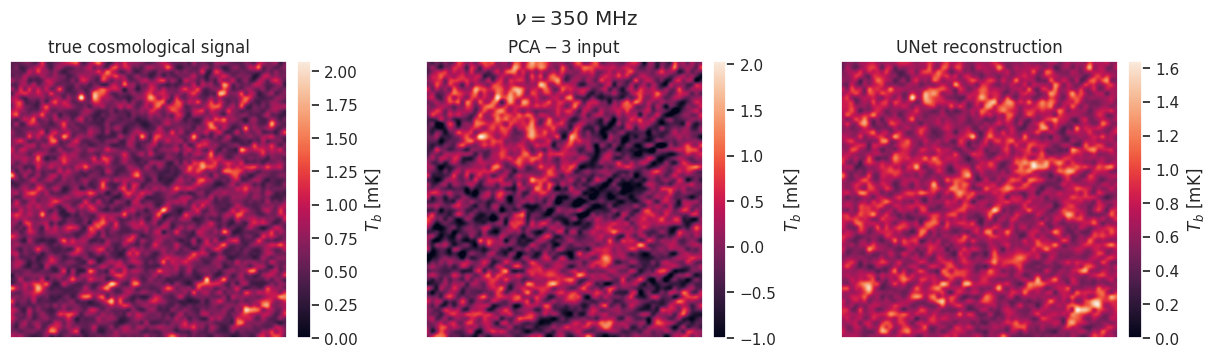

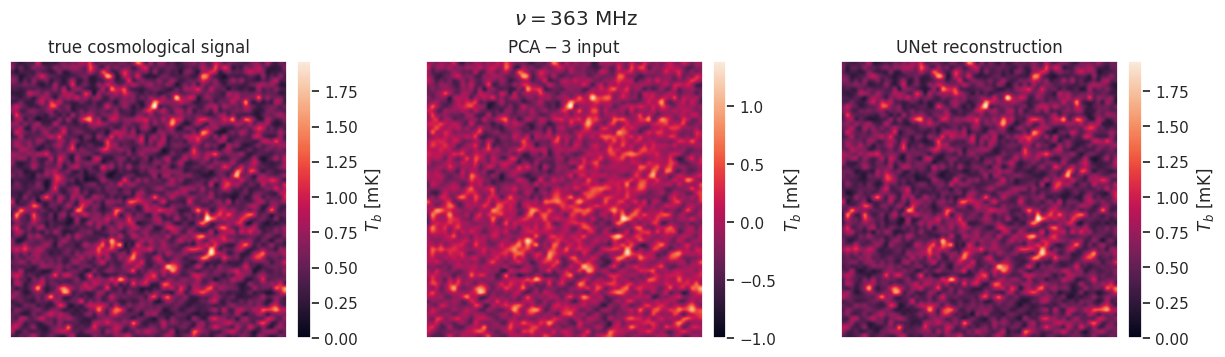

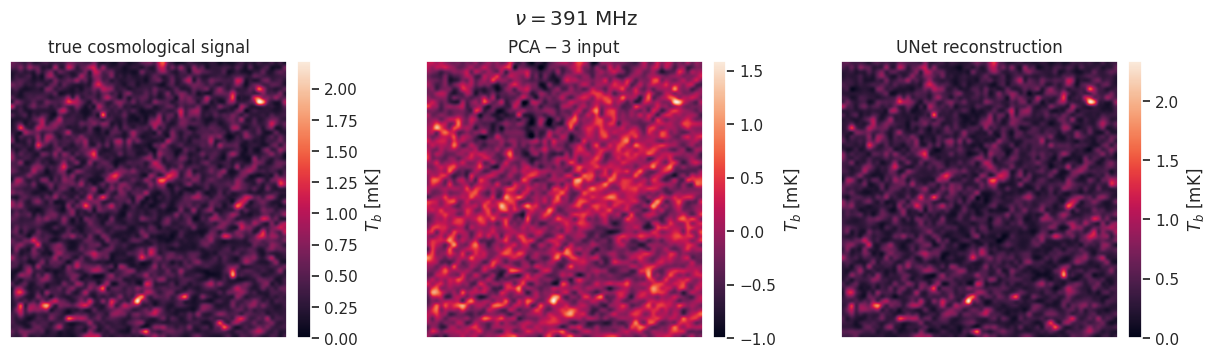

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# actual frequencies
nutable = './sim_info/nuTable.txt'
(bn,nu_bot,nu_top,z_bot,z_top) = np.loadtxt(nutable).T
nu_arr = ((nu_bot + nu_top)/2.)[:-1]

# which frequencies we want to plot
nu_indx = [0, 20, 60]
for nu in nu_indx:
  pick = 5

  xval_c1 = np.squeeze(x_test)[pick].T
  yval_c1 = np.squeeze(y_test)[pick].transpose()
  y_c1_pred = np.squeeze(y_pred)[pick].transpose()

  fig,axs = plt.subplots(constrained_layout=True)

  ax1 = plt.subplot(131)
  im = ax1.imshow(yval_c1[nu], vmin=0, rasterized=True,
                  interpolation='spline16')

  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  divider = make_axes_locatable(ax1)
  cax = divider.append_axes("right", size="5%", pad=0.1)
  cbar = plt.colorbar(im, cax=cax)
  cbar.set_label(r'$T_b\ \rm [mK]$')
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_title(r"true cosmological signal")


  ax1 = plt.subplot(132)
  im = plt.imshow(xval_c1[nu], vmin=-1, rasterized=True,
                  interpolation='spline16')

  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  divider = make_axes_locatable(ax1)
  cax = divider.append_axes("right", size="5%", pad=0.1)
  cbar = plt.colorbar(im, cax=cax)


  cbar.set_label(r'$T_b\ \rm [mK]$')
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_title(r"$\rm PCA-3 $ input")



  ax1 = plt.subplot(133)
  im = plt.imshow(y_c1_pred[nu], vmin=0, rasterized=True,
                  interpolation='spline16')

  divider = make_axes_locatable(ax1)
  cax = divider.append_axes("right", size="5%", pad=0.1)
  cbar = plt.colorbar(im, cax=cax)

  cbar.set_label(r'$T_b\ \rm [mK]$')

  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_title(r"UNet reconstruction")


  plt.suptitle(r'$\nu = $%03d'%(nu_arr[nu]) + r' $\rm MHz$')

  plt.gcf().set_size_inches((3.7* 3.37, 3.37))

  plt.show()

So even with a few epochs (and only one full-sky simulation), we see that the UNet does a decent job of reconstructing the cosmological signal.
___

(We could alternatively load a pre-trained model and weights from the repository.)

Let's see how well the UNet captures the temperature distribution over frequency compared with the PCA-3 inputs:

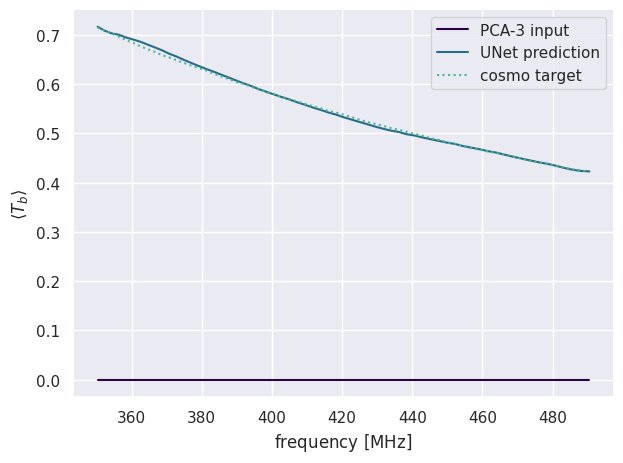

In [24]:
# see how the mean temperatures line up
plt.plot(nu_arr[:192][::3], [np.mean(t) for t in np.squeeze(x_test).T],
         color=colors[0], label='PCA-3 input')

plt.plot(nu_arr[:192][::3], [np.mean(t) for t in np.squeeze(y_pred).T],
         color=colors[2], label='UNet prediction')
plt.plot(nu_arr[:192][::3], [np.mean(t) for t in np.squeeze(y_test).T],
         color = colors[3], linestyle=':', label='cosmo target')

plt.ylabel(r'$\langle T_b \rangle$')
plt.xlabel(r'frequency $\rm [MHz]$')
plt.legend()
plt.tight_layout()
plt.show()

# power spectra
An important way of quantifying cosmological maps is through clustering statistics obtained from maps such as power spectra. Here we'll take a look at angular clustering at a few different frequencies, first of the cleaning residual (how much is left over after we've implemented a cleaning algorithm) -- then we'll look at the bias introduced by cleaning on the target power spectrum

**Note:** for this part of the tutorial, we need to have a prediction made *over an entire sky*.

In [25]:
def angularPowerSpec(y_true, prediction, nu_select,
                     nu_arr, index_array, nu_avg=3):

    rearr = index_array
    nwinds = hp.nside2npix(4)

    # true map
    cosmo_test = (np.array_split(y_true, y_true.shape[0] // nwinds))

    # cleaned map
    y_pred = (np.array_split(prediction, prediction.shape[0] // nwinds))

    # residual map
    y_res = (np.array_split((prediction - y_true), y_true.shape[0] // nwinds))


    cosmo_Cl = []   # Cls for cosmo spectra
    pred_Cl  = []   # Cls for predicted spectra
    res_Cl   = []   # Cls for residual spectra

    for i,nu in enumerate(nu_select):

        # Get Cls for COSMO spectrum
        # loops over nsims test set skies
        cos = []
        for cosmo in cosmo_test:
            cosmo0 = (cosmo.T[nu].T).flatten()
            cosmo0 = cosmo0[rearr]
            alm_cosmo = hp.map2alm(cosmo0)
            Cl_cosmo = hp.alm2cl(alm_cosmo)
            cos.append(Cl_cosmo)

        # save average of Cl over nsims
        cosmo_Cl.append(np.mean(cos, axis=0))


        # Get Cls for the predicted maps
        predicted_cl = []
        for y in y_pred:
            y0 = (y.T[nu].T).flatten()
            y0 = y0[rearr]
            alm_y = hp.map2alm(y0)
            Cl_y = hp.alm2cl(alm_y)
            predicted_cl.append(Cl_y)

        # save average of Cl over nsims
        pred_Cl.append(np.mean(predicted_cl, axis=0))


        # Get Cls for the residual maps
        residual_cl = []
        for y in y_res:
            y0 = (y.T[nu].T).flatten()
            y0 = y0[rearr]
            alm_y = hp.map2alm(y0)
            Cl_y = hp.alm2cl(alm_y)
            residual_cl.append(Cl_y)

        # save average of Cl over nsims
        res_Cl.append(np.mean(residual_cl, axis=0))


    return np.array(cosmo_Cl), np.array(pred_Cl), np.array(res_Cl)

In [26]:
%%time
#  squeeze out extra dims
unet_prediction = np.squeeze(y_pred)
cosmo_target = np.squeeze(y_test)
pca3_prediction = np.squeeze(x_test)

# which frequencies do we want to look at ? Let's do the same as the cutouts above
nu_indx = [0, 20, 60]

cosmo_cl, unet_cl, unet_res_cl = angularPowerSpec(cosmo_target, unet_prediction,
                                                  nu_indx, nu_arr, index_arr)

cosmo_cl, pca3_cl, pca3_res_cl = angularPowerSpec(cosmo_target, pca3_prediction,
                                                  nu_indx, nu_arr, index_arr)

CPU times: user 29.2 s, sys: 653 ms, total: 29.8 s
Wall time: 17.8 s


## residual map statistics
Just how clean are the maps we've produced via the UNet method ? To quantify this, we'll take a look at the $\rho_{\rm res}$ statistic we introduced in the `deep21` paper. We define the *residual map* as $\textbf{p} - \textbf{t}$, where $\textbf{p}$ and $\textbf{t}$ are prediction and target maps, respectively. The power spectrum of this residual is then
$$ \rho_{\rm res} = \frac{P(\textbf{p} - \textbf{t})}{P(\textbf{t})} $$
where $P(\cdot)$ is the power spectrum for a given orientation. We'll take a look at the angular power spectrum here, computed via the `healpy` library. The angular power spectrum decomposes a sky map (at a given radio frequency) into spherical harmonics, with $\ell$ indexing the scale of signal fluctuations. Small $\ell$ corresponds to the largest scales, while large $\ell$ indexes small angular correlations.

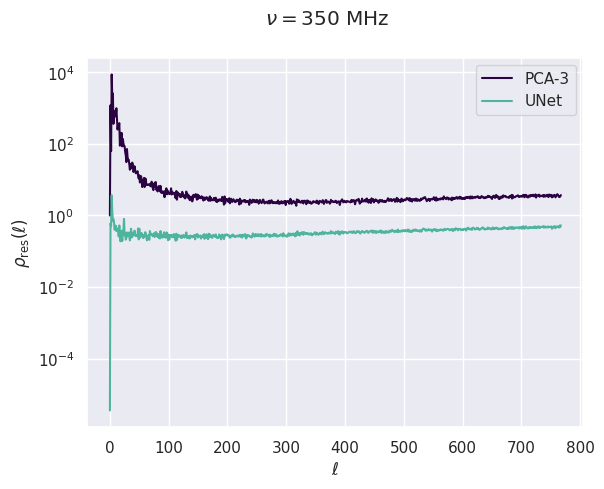

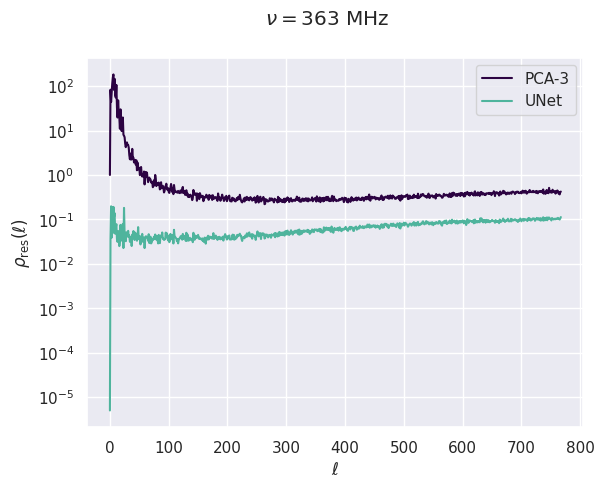

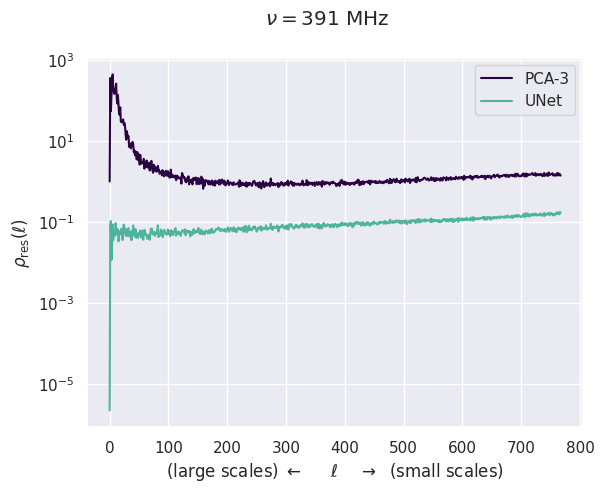

In [27]:
for i,nu in enumerate(nu_indx):
    plt.plot(pca3_res_cl[i] / cosmo_cl[i],
            c=colors[0], label='PCA-3')
    plt.plot(unet_res_cl[i] / cosmo_cl[i],
            c=colors[3], label='UNet')

    plt.yscale('log')
    plt.ylabel(r'$\rho_{\rm res}(\ell)$')

    if i == len(nu_indx)-1:
        plt.xlabel(r'(large scales) $\leftarrow$     $\ell$    $\rightarrow$  (small scales)')

    else:
        plt.xlabel(r'$\ell$')

    plt.suptitle(r'$\nu = $%03d'%(nu_arr[nu]) + r' $\rm MHz$')
    plt.legend()
    plt.show()

## summary statistic bias

We've demonstrated that in this noise-free, simple example that our maps appear qualitatively similar to the target cosmological signal. Many current cosmological analyses (references ?), however  rely on compressed summary statistics derived from compressed maps. In the publication we introduced the metric
$$ \varepsilon(k) = \frac{P(\textbf{p}) - P(\textbf{t})}{P(\textbf{t})} $$

which quantifies the *bias* a map-cleaning method imposes on the derived summary statistic


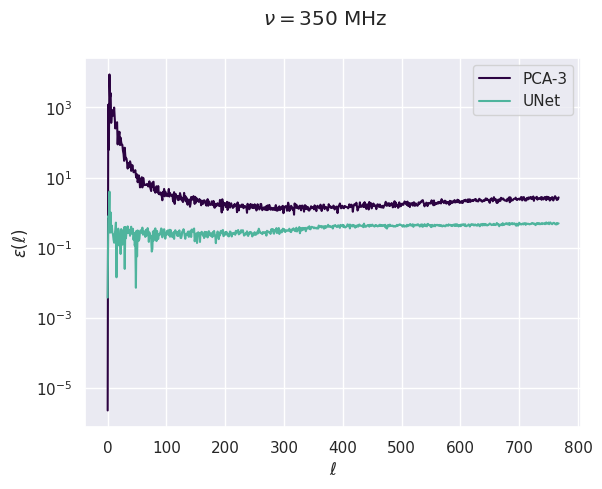

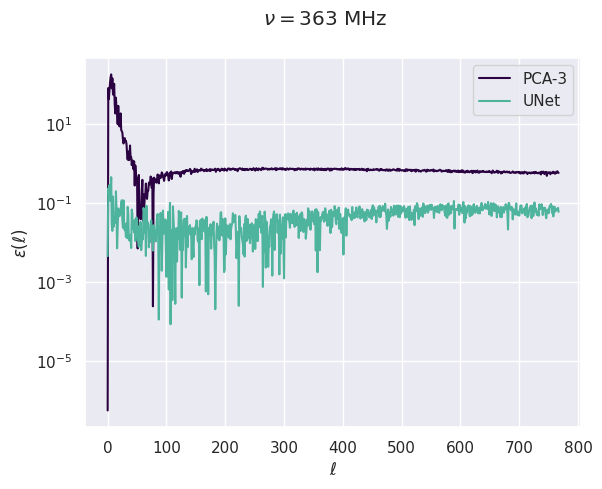

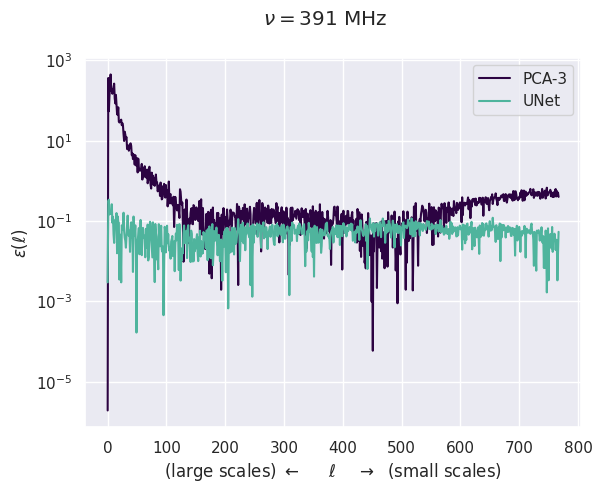

In [28]:
for i,nu in enumerate(nu_indx):

    plt.plot(np.abs(pca3_res_cl[i] - cosmo_cl[i]) / cosmo_cl[i],
             c=colors[0],label='PCA-3')
    plt.plot(np.abs(unet_cl[i] - cosmo_cl[i]) / cosmo_cl[i],
             c=colors[3],label='UNet')
    plt.yscale('log')
    plt.ylabel(r'$\varepsilon(\ell)$')

    if i == len(nu_indx)-1:
        plt.xlabel(r'(large scales) $\leftarrow$     $\ell$    $\rightarrow$  (small scales)')

    else:
        plt.xlabel(r'$\ell$')

    plt.suptitle(r'$\nu = $%03d'%(nu_arr[nu]) + r' $\rm MHz$')

    plt.legend()
    plt.show()

Computing the this statistic reveals that the UNet very capably reduces bias on the expected power spectrum, hovering around 10% of the target spectrum at all three frequencies that we extracted from the test set. At higher frequencies, PCA-3 is more capable at resolving foregrounds and cosmological signal. However, the UNet is by far more consistent across frequency and at all angular scales.
